# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutoria](https://waterprogramming.wordpress.com/2017/11/19/open-exploration-with-the-exploratory-modelling-workbench/) for help.

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.

In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [2]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

n_policies = 10
n_scenarios = 1000

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: you can use either pandas or numpy.lib.recfunctions for dropping columsn from the experiments recarray*



In [3]:
import numpy.lib.recfunctions as rf

experiments, outcomes = results
lever_names = [l.name for l in lake_model.levers]
experiments = rf.drop_fields(experiments, drop_names=lever_names+['policy'], 
                             asrecarray=True)

Apply scenario discovery, focussing on the 10 percent of worst outcomes for maximum pollution. 

* show tradeoff curve
* inspect several boxes, using both tables and graphs


In [4]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes['reliability'] <= np.percentile(outcomes['reliability'], 10)

prim_alg = prim.Prim(x,y, threshold=0.8)
box1 = prim_alg.find_box()


[MainProcess/INFO] 10000 points remaining, containing 760 cases of interest
[MainProcess/INFO] mean: 0.8490196078431372, mass: 0.051, coverage: 0.5697368421052632, density: 0.8490196078431372 restricted_dimensions: 3


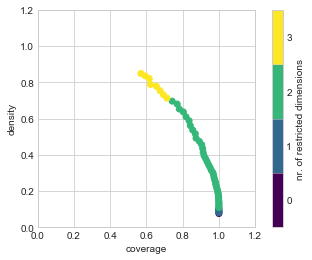

In [5]:
box1.show_tradeoff()
plt.show()

In [6]:
box1.inspect()

coverage    0.569737
density      0.84902
id                55
mass           0.051
mean         0.84902
res_dim            3
Name: 55, dtype: object

        box 55                                          
           min       max                       qp values
q     2.001969  2.600410  [0.0, 2.1224176793882663e-173]
b     0.100297  0.196601   [0.0, 1.299860923552747e-158]
mean  0.018566  0.049971     [4.08331164533732e-05, 0.0]



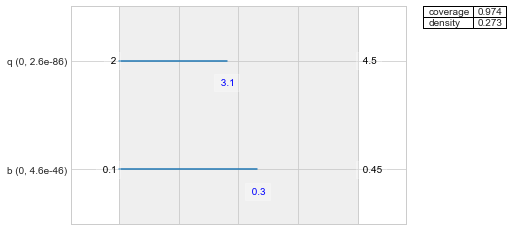

In [7]:
box1.inspect(25, style='graph')
plt.show()

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

We can use dimensional stacking for this. We set nr_levels to 2, because we only need 3 uncertainties to properly show the results. 


/Users/jhkwakkel/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


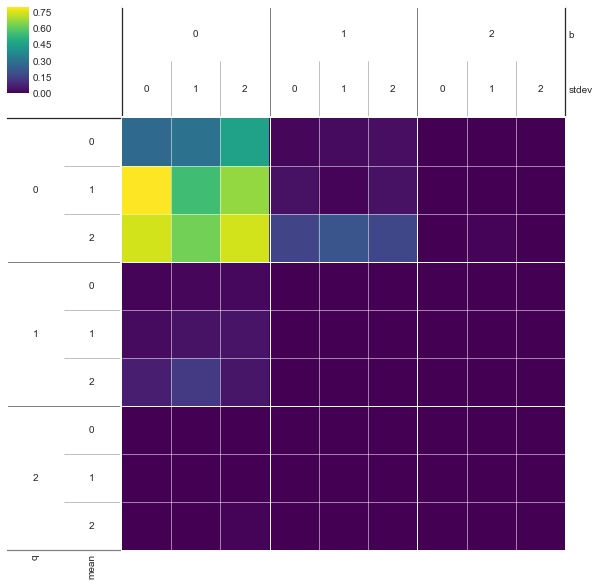

In [8]:
from ema_workbench.analysis import dimensional_stacking

dimensional_stacking.create_pivot_plot(x,y, nr_levels=2)
plt.show()

We see that a low value for q and b primarily drives the results. In line with the prim analysis. There is also some sensitivity to higher values of mean, and occassionaly policy also has some influence. However, the latter was not shown by the PRIM analysis. 

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. Generate 10 random release policies. Generate 1000 experiments, and analyse the results using extra trees feature scoring for all outcomes of interest. What can you tell about the difference in sensitivity across the different outcomes of interest?

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*

In [17]:
from ema_workbench.analysis import feature_scoring

scores = feature_scoring.get_feature_scores_all(x, outcomes)

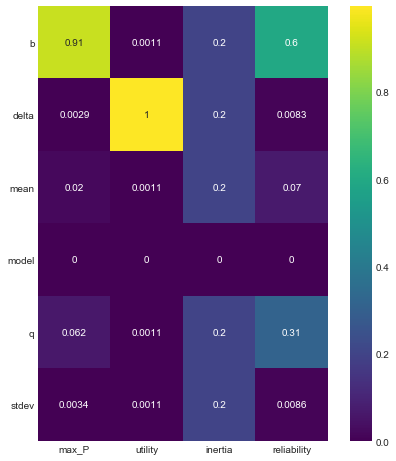

In [18]:
ax = sns.heatmap(scores, cmap='viridis', annot=True)

ax.set_aspect('equal')
fig = plt.gcf()
fig.set_size_inches(8,8)

plt.yticks(rotation=0)

plt.show()

* max_P is driven primarily by B
* utility is driven by delta
* inertia is solely driven by policy. This you could have known given the equations of the model.
* reliability is driven by b, q, and a little bit by the mean. This is consistent with the scenario discovery results